In [1]:
import numpy as np
import pandas as pd
import copy #Use for Deep copy

import seaborn as sns
import matplotlib.pyplot as plt

# Open the response matrix saved previously

In [2]:
with open('D:\\decertation\\data\\WVSCM\\new code\\response_matrix.npy', 'rb') as f:
    response_matrix = np.load(f)
print(response_matrix)

[[ 1  0  0 ... -1 -1 -1]
 [ 0  0  0 ...  1  1 -1]
 [ 0  0  1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


# Open the gold result

In [3]:
train = pd.read_csv('D:\\decertation\\data\\WVSCM\\new code\\new_gold.csv')
print(train.head())

   Unnamed: 0  Question_id  Question_Reduced_Id  Gold_level
0           0         2001                 1973           1
1           1         2002                 1974           0
2           2         2003                 1975           0
3           3         2004                 1976           1
4           4         2005                 1977           0


# No of 0 and 1 in gold data

In [4]:
po, ne, gold_total = 0, 0, 0
for i in range(len(train['Gold_level'])):
    if train['Gold_level'][i] == 0:
        ne += 1

    elif train['Gold_level'][i] == 1:
        po += 1
    
    gold_total += 1
        
print(f'In gold data Positive : {po}, Negetive : {ne}')

In gold data Positive : 58, Negetive : 102


In [5]:
c, r = len(np.unique(response_matrix))-1, response_matrix.shape[1]
p = r * c

In [6]:
tot_ques = r
print(f'Total question : {tot_ques}')

Total question : 2135


# Work with response matrix

# Calculating accuracy of annotators using train set

In [7]:
s1 = int(len(train)* 0.3)
train2 = train[:s1]

In [8]:
accuracy = [1 / len(train2)]*response_matrix.shape[0]
for i in range (response_matrix.shape[0]):
    tot, corr = 0.0, 0.0
    for j in range(len(train2)):
        if -1 != response_matrix[i][train2[train2.columns[2]][j]]:
            tot += 1
            if train2[train.columns[3]][j] == response_matrix[i][train2[train2.columns[2]][j]]:
                corr += 1
    if tot != 0:
        accuracy[i] += corr / tot
        
accuracy = ((accuracy - np.min(accuracy))/ (np.max(accuracy)-(np.min(accuracy)))) * 0.5

In [9]:
accuracy[:5]

array([0.        , 0.33333333, 0.        , 0.        , 0.28571429])

# Required Functions

In [10]:
def dist(a,b):
    s = 0
    for j in range(len(a)):
        if a[j] != b[j]:
            s += 1
    return s

In [11]:
def local_directory(row):
    local_dict = {}
    local_dict['vector'] = row
    local_dict['frequency'] = 1
    
    s = 0  
    for j in range (len(row)):
        if row[j] != -1:
            s += 1
    local_dict['response_number'] = s
    
    return local_dict

In [12]:
#Cluster with distance = hyp
def cluster(cluster_dict, block, hyp):
    cluster_id = []
    distance, i = 0, len(cluster_dict)
    for j in range(len(block)):
        if len(cluster_dict) == 0:
            i += 1
            cluster_dict[i] = local_directory(block[j])
            cluster_id.append(i)
            distance += 0

        else:
            l, k = 1, i
            while l <= k:
                d = dist(block[j], cluster_dict[l]['vector'])
                if d <= hyp:
                    cluster_dict[l]['frequency'] += 1
                    cluster_id.append(l)
                    distance += d

                    break
                else:
                    l += 1
                if l == k+1:
                    i += 1
                    cluster_dict[i] = local_directory(block[j])
                    cluster_id.append(i)
                    distance += 0

    return cluster_dict, cluster_id, distance


In [13]:
#Clustering with finding the distance
def clustering(cluster_dict, block, d):
    # Use ELBOW Method to find the threshold of the distance
    distance_list = []
    
    for it in range (1,100):
        k = it * 100
        cluster_dictionary = copy.deepcopy(cluster_dict)
        _, _, distance = cluster(cluster_dictionary, block, k)
        distance_list.append(distance)
        
    ratio, ratio1, index, ind_ch = [], [], [], []
    for i in range(1, len(distance_list)):
        a = (distance_list[i]-distance_list[i-1])/100
        ratio.append(a)
        if a != 0:
            ratio1.append(a)
            index.append(i)

    for i in range(1, len(index)):
        ind_ch.append((ratio1[i] - ratio1[i-1])/(index[i]-index[i-1]))

    dis = d    
    for index in range(1, len(ind_ch)):
        if ind_ch[index] >= 1:
            a = ind_ch.index(ind_ch[index]) + 1
            dis = ratio.index(ratio1[a])*100
            break
                
#     cluster_dict,cluster_id, _ = cluster(cluster_dict, block, dis)   
    return cluster_dict, dis

In [14]:
def judge(J, block, cluster_dict, a, dis):    
    cluster_dict, cluster_id, dis = cluster(cluster_dict, block, dis)
    weight = []

    for k in range(block.shape[0]):
        w = accuracy[a + k] + const * cluster_dict[cluster_id[k]]['response_number']/cluster_dict[cluster_id[k]]['frequency']
        weight.append(w)
    
    for j in range(block.shape[1]):
        for k in range(block.shape[0]):
            if block[k][j] != -1:
                J[j][block[k][j]] += weight[k]
    return J, cluster_dict

# main function

In [15]:
const = 0.001
dis = 1000
cluster_dict = {}
J = np.array([0.]*p).reshape(r, c)
Result = np.array([-1]*r)

In [16]:
a, b = 0, 16

A = response_matrix[a : b]
_, dis = clustering(cluster_dict, A, dis)


# step = 1
while b <= response_matrix.shape[0]:
#     print(f'step = {step}')
#     step += 1
    A = response_matrix[a : b]
    J, cluster_dict = judge(J, A, cluster_dict, a, dis)
    
    # Calculate final result
    for j in range(J.shape[0]):
        Result[j] = np.argmax(J[j])
    
    #Calculate accuracy
    right = 0
    for j in range(len(train)):
        if train[train.columns[3]][j] == Result[train[train.columns[2]][j]]:
            right += 1
            
    print(f'Accuracy after {b} annotators\' response is {right / len(train) * 100 :.4f} %')
    
    a = b
    b += 16

Accuracy after 16 annotators' response is 70.0000 %
Accuracy after 32 annotators' response is 74.3750 %
Accuracy after 48 annotators' response is 70.6250 %
Accuracy after 64 annotators' response is 73.1250 %


# Confusion matrix

In [17]:
Conf = np.zeros((2,2), dtype = 'int64')

In [18]:
for j in range(len(train)):
    if train[train.columns[3]][j] == 1:
        if train[train.columns[3]][j] == Result[train[train.columns[2]][j]]:
            Conf[0][0] += 1
        else:
            Conf[1][0] += 1
    if train[train.columns[3]][j] == 0:
        if train[train.columns[3]][j] == Result[train[train.columns[2]][j]]:
            Conf[1][1] += 1
        else:
            Conf[0][1] += 1
print(Conf)

[[42 27]
 [16 75]]


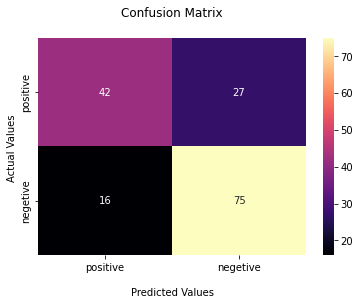

In [19]:
ax = sns.heatmap(Conf, annot=True, cmap = plt.cm.magma)

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(i for i in ('positive', 'negetive'))
ax.yaxis.set_ticklabels(i for i in ('positive', 'negetive'))
plt.show()

In [20]:
accuracy1 = [1 / len(train)]*response_matrix.shape[0]
for i in range (response_matrix.shape[0]):
    tot, corr = 0.0, 0.0
    for j in range(len(train)):
        if -1 != response_matrix[i][train[train.columns[2]][j]]:
            tot += 1
            if train[train.columns[3]][j] == response_matrix[i][train[train.columns[2]][j]]:
                corr += 1
    if tot != 0:
        accuracy1[i] += corr / tot
        

In [21]:
s = 0
for i in range (len(accuracy1)):
    if accuracy1[i] >= 0.5:
        s += 1
        
print(s)

14


In [22]:
len(accuracy1)

64